## Пример множественной линейной регрессии

### Подготовка переменных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
from scipy import stats

In [2]:
df = pd.read_excel('v2_funding_rounds.xlsx', sheet_name=0, header=0)
df

,Money Raised (in USD),Announced Date,Organization Name,Funding Type (dummy),Organization Industries,ВВП на душу населения,Уровень процентных ставок,Инфляция,Темпы роста экономики,Индекс глобальной инновационной активности (GII),Доля корпоративных венчурных фондов (CVC),Доля государственного финансирования в венчурных инвестициях,Индекс политической стабильности
0,4000000,2012-03-02,Zoona,Series A,"Financial Services, FinTech, Mobile, Software",434.40,0.050,0.056,0.025,37.40,0.03,0.49,0.60
1,750000,2014-06-02,Wyzetalk,Series A,Information Technology,381.20,0.055,0.061,0.015,38.25,0.12,0.41,0.60
2,800000,2015-07-09,Faithful to Nature,Seed,"E-Commerce, Food and Beverage, Health Care, Or...",346.66,0.060,0.046,0.013,37.45,0.15,0.44,0.60
3,2000,2016-03-14,South African Digital Enterprise,Pre-Seed,"Digital Marketing, Digital Media, Telecommunic...",323.49,0.070,0.063,0.003,35.85,0.13,0.40,0.60
4,9000000,2016-10-19,SPARK Schools,Series B,"Charter Schools, Education, Skill Assessment",323.49,0.070,0.063,0.003,35.85,0.13,0.40,0.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...
204,400000,2024-09-12,Pumpkn,Seed,"Financial Services, FinTech, Small and Medium ...",403.00,0.080,0.045,0.006,28.30,0.16,0.05,0.74
205,1819175,2024-09-17,Happy Pay,Pre-Seed,"Finance, Financial Services, Shopping",403.00,0.080,0.045,0.006,28.30,0.16,0.05,0.74
206,250000,2024-11-07,Abalobi,Seed,"Mobile, Mobile Apps, Software",403.00,0.080,0.045,0.006,28.30,0.16,0.05,0.74
207,120000,2024-12-22,Starbuy Exchange,Seed,"Cryptocurrency, FinTech",403.00,0.080,0.045,0.006,28.30,0.16,0.05,0.74


In [3]:
# преобразование иерархической номинативной переменной
df['Funding Type (dummy)'] = df['Funding Type (dummy)'].map({'Pre-Seed':1, 'Seed':2, 'Series A':3, 'Series B':4})

In [4]:
# предикторы выбраны заказчиком
df_for_reg_model = df.copy(deep=True)
df_for_reg_model = df_for_reg_model.reindex(columns=['Money Raised (in USD)', 'ВВП на душу населения', 'Уровень процентных ставок', 'Инфляция', 'Темпы роста экономики',
                                                     'Индекс глобальной инновационной активности (GII)', 'Доля корпоративных венчурных фондов (CVC)',
                                                     'Доля государственного финансирования в венчурных инвестициях', 'Индекс политической стабильности', 'Funding Type (dummy)'])
df_for_reg_model.head(3)

,Money Raised (in USD),ВВП на душу населения,Уровень процентных ставок,Инфляция,Темпы роста экономики,Индекс глобальной инновационной активности (GII),Доля корпоративных венчурных фондов (CVC),Доля государственного финансирования в венчурных инвестициях,Индекс политической стабильности,Funding Type (dummy)
0,4000000,434.40,0.050,0.056,0.025,37.40,0.03,0.49,0.6,3
1,750000,381.20,0.055,0.061,0.015,38.25,0.12,0.41,0.6,3
2,800000,346.66,0.060,0.046,0.013,37.45,0.15,0.44,0.6,2


In [5]:
reg_model_dict = {'Money Raised (in USD)':'y',
                  'ВВП на душу населения':'x_1',
                  'Уровень процентных ставок':'x_2',
                  'Инфляция':'x_3',
                  'Темпы роста экономики':'x_4',
                  'Индекс глобальной инновационной активности (GII)':'x_5',
                  'Доля корпоративных венчурных фондов (CVC)':'x_6',
                  'Доля государственного финансирования в венчурных инвестициях':'x_7',
                  'Индекс политической стабильности':'x_8',
                  'Funding Type (dummy)': 'x_9'}
df_for_reg_model = df_for_reg_model.rename(columns=reg_model_dict)

> меняем названия у колонок, чтобы в коде не возникали конфликты с названиями переменных (формулы statsmodels конфликтуют с пробелами с названиями) + на графиках визуально легче воспринимать короткие названия переменных

> у - это зависимая переменная, все остальные - пронумерованные предикторы х

In [6]:
df_for_reg_model

,y,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9
0,4000000,434.40,0.050,0.056,0.025,37.40,0.03,0.49,0.60,3
1,750000,381.20,0.055,0.061,0.015,38.25,0.12,0.41,0.60,3
2,800000,346.66,0.060,0.046,0.013,37.45,0.15,0.44,0.60,2
3,2000,323.49,0.070,0.063,0.003,35.85,0.13,0.40,0.60,1
4,9000000,323.49,0.070,0.063,0.003,35.85,0.13,0.40,0.60,4
...,...,...,...,...,...,...,...,...,...,...
204,400000,403.00,0.080,0.045,0.006,28.30,0.16,0.05,0.74,2
205,1819175,403.00,0.080,0.045,0.006,28.30,0.16,0.05,0.74,1
206,250000,403.00,0.080,0.045,0.006,28.30,0.16,0.05,0.74,2
207,120000,403.00,0.080,0.045,0.006,28.30,0.16,0.05,0.74,2


### Первичная оценка переменных и модели

<Axes: >

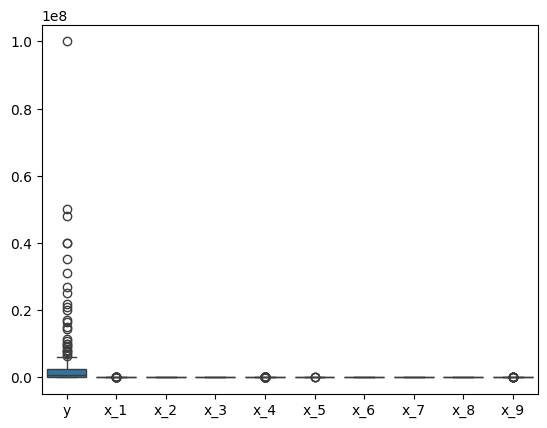

In [7]:
# распределение переменных
sns.boxplot(data=df_for_reg_model)

In [8]:
y = df_for_reg_model['y']
x = sm.add_constant(df_for_reg_model[['x_1', 'x_2', 'x_3', 'x_4', 'x_5', 'x_6', 'x_7', 'x_8', 'x_9']])

In [9]:
# первичная модель
model = sm.OLS(y, x).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.279
Model:                            OLS   Adj. R-squared:                  0.247
Method:                 Least Squares   F-statistic:                     8.573
Date:                Thu, 18 Sep 2025   Prob (F-statistic):           8.01e-11
Time:                        21:28:02   Log-Likelihood:                -3637.0
No. Observations:                 209   AIC:                             7294.
Df Residuals:                     199   BIC:                             7327.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -7.577e+07   1.86e+08     -0.407      0.6

>**Первичная модель**

> - Объясняемость (Adj. R-squared) = 25%
> - Остаки распределены не нормально (Omnibus > 0)

In [10]:
# логарифмируем у как самую ненормально распределённую переменную
df_for_reg_model = df_for_reg_model.dropna(how='any').reset_index(drop=True)
df_for_reg_model['y'] = np.log2(df_for_reg_model['y'])
df_for_reg_model

,y,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9
0,21.931569,434.40,0.050,0.056,0.025,37.40,0.03,0.49,0.60,3
1,19.516531,381.20,0.055,0.061,0.015,38.25,0.12,0.41,0.60,3
2,19.609640,346.66,0.060,0.046,0.013,37.45,0.15,0.44,0.60,2
3,10.965784,323.49,0.070,0.063,0.003,35.85,0.13,0.40,0.60,1
4,23.101494,323.49,0.070,0.063,0.003,35.85,0.13,0.40,0.60,4
...,...,...,...,...,...,...,...,...,...,...
204,18.609640,403.00,0.080,0.045,0.006,28.30,0.16,0.05,0.74,2
205,20.794853,403.00,0.080,0.045,0.006,28.30,0.16,0.05,0.74,1
206,17.931569,403.00,0.080,0.045,0.006,28.30,0.16,0.05,0.74,2
207,16.872675,403.00,0.080,0.045,0.006,28.30,0.16,0.05,0.74,2


> распределение переменных стало больше похожим на нормальное, см. график ниже

<Axes: >

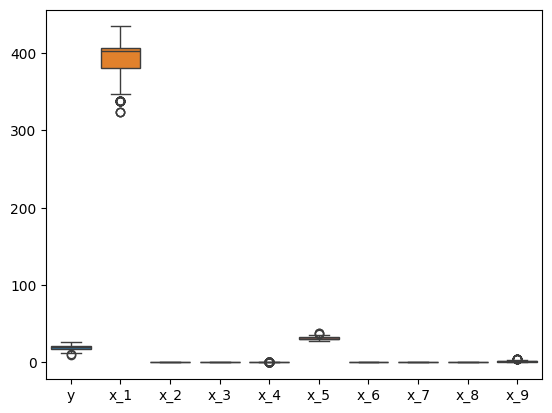

In [11]:
sns.boxplot(data=df_for_reg_model)

In [12]:
y = df_for_reg_model['y']
x = sm.add_constant(df_for_reg_model[['x_1', 'x_2', 'x_3', 'x_4', 'x_5', 'x_6', 'x_7', 'x_8', 'x_9']])

model = sm.OLS(y, x).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.440
Model:                            OLS   Adj. R-squared:                  0.414
Method:                 Least Squares   F-statistic:                     17.34
Date:                Thu, 18 Sep 2025   Prob (F-statistic):           5.15e-21
Time:                        21:28:02   Log-Likelihood:                -464.15
No. Observations:                 209   AIC:                             948.3
Df Residuals:                     199   BIC:                             981.7
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -65.7549     47.476     -1.385      0.1

> **Модель со всеми переменными**

> - построив модель со всеми переменными Х, мы получили R-квадрат поправкой на множественное сравнение (Adj. R-square) равный 41%
> - снился AIC (информационный критерий Акаике) и увеличился Log-Likelihood (значение правдоподобия)
> - показатель распределения остатков (Omnibus) тоже снизился, но всё ещё больше 0
> - t-статистика и p-value показывают недостаточную значимость большинства предикторов для модели на данном этапе её построения

> Стоит улучшить подель проверкой на мультиколлинеарность

### Проверка на мультиколлинеарность

<Axes: >

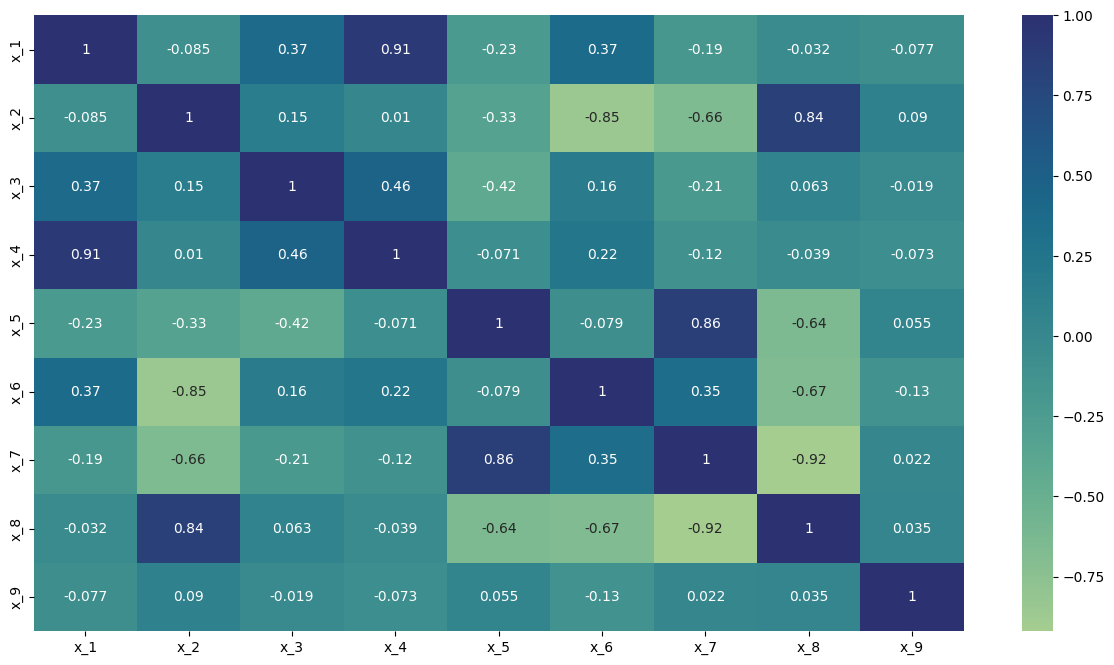

In [13]:
plt.figure(figsize=(15, 8))
sns.heatmap(df_for_reg_model[['x_1', 'x_2', 'x_3', 'x_4', 'x_5', 'x_6', 'x_7', 'x_8', 'x_9']].corr(), annot=True, cbar=True, cmap='crest')

> уберём x_2 (Уровень процентных ставок), x_4 (Темпы роста экономики), x_8 (Индекс политической стабильности), х_7 (Доля государственного финансирования в венчурных инвестициях) из-за наличия тесной линейной зависимости с остальными предикторами

In [14]:
# убираем 2 столбца: x_2, x_4, х_7, x_8

df_for_reg_model = df_for_reg_model.reindex(columns=['y', 'x_1', 'x_3', 'x_5', 'x_6', 'x_9'])

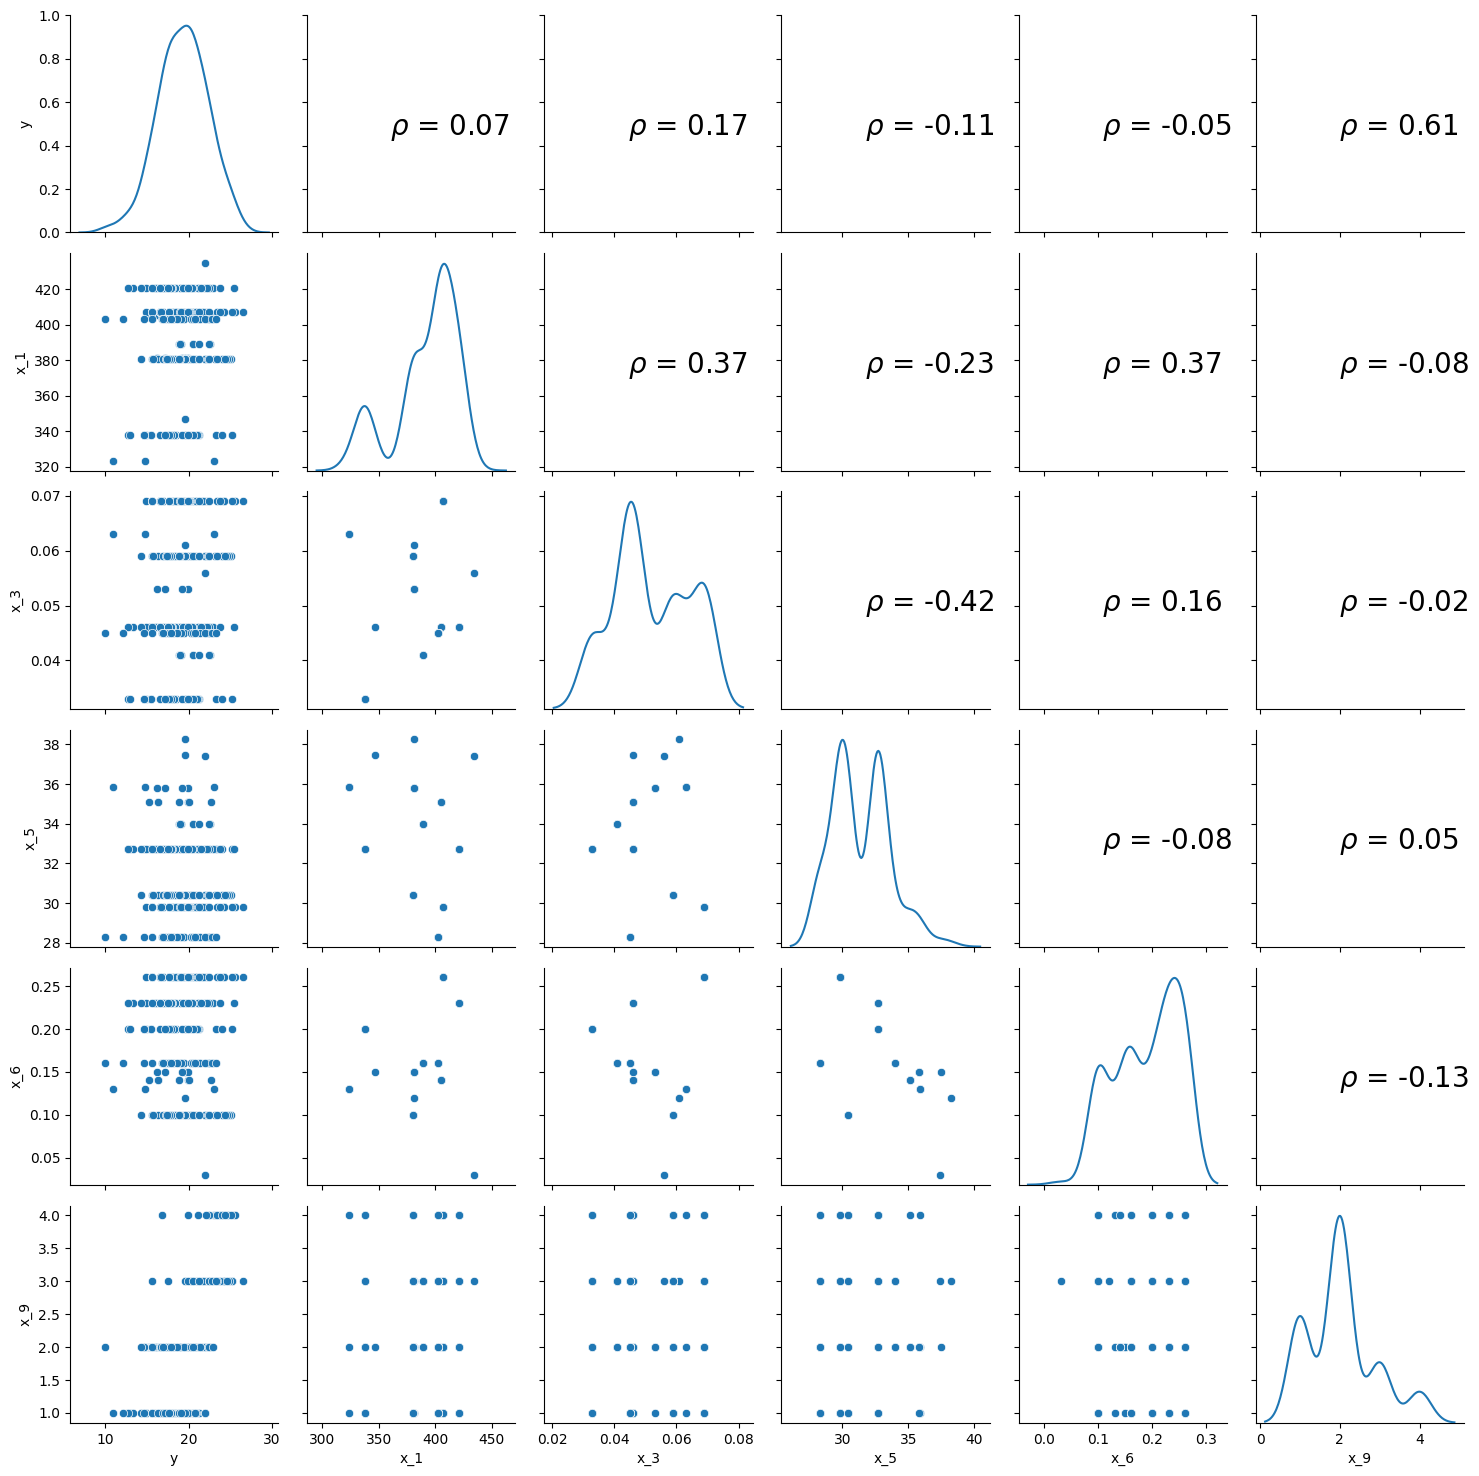

In [15]:
# Function to calculate correlation coefficient between two arrays
def corr(x, y, **kwargs):
    # Calculate the value
    coef = np.corrcoef(x, y)[0][1]
    # Make the label
    label = r'$\rho$ = ' + str(round(coef, 2))
    # Add the label to the plot
    ax = plt.gca()
    ax.annotate(label, xy = (0.4, 0.45), size = 20, xycoords = ax.transAxes)

g = sns.PairGrid(df_for_reg_model, diag_sharey=False)
g.map_upper(corr)
g.map_lower(sns.scatterplot)
g.map_diag(sns.kdeplot)

### Подбор наилучшей модели

In [16]:
y = df_for_reg_model['y']
x = sm.add_constant(df_for_reg_model[['x_1', 'x_3', 'x_5', 'x_6', 'x_9']])

model = sm.OLS(y, x).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.412
Model:                            OLS   Adj. R-squared:                  0.397
Method:                 Least Squares   F-statistic:                     28.41
Date:                Thu, 18 Sep 2025   Prob (F-statistic):           8.70e-22
Time:                        21:28:05   Log-Likelihood:                -469.21
No. Observations:                 209   AIC:                             950.4
Df Residuals:                     203   BIC:                             970.5
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         14.4835      3.935      3.680      0.0

In [17]:
# Рекурсивно переберём все сочетания переменных
fits = {'x_1', 'x_3', 'x_5', 'x_6', 'x_9'}

def check_all_x(params: set, formula: str, result: set) -> str:
    if not params:
        result.add(formula.lstrip('+ '))
        return 
    else:
        new_params = params.copy()
        for el in params:
            new_params.remove(el)

            check_all_x(new_params, formula + ' + ' + el, result)
            check_all_x(new_params, formula, result)

res = set()          
check_all_x(fits, '', res)
res.remove('')

df_fits = pd.DataFrame(columns=['adj_r-square', 'aic', 'fits'])

# Теперь посчитаем Adjusted R-Square для каждого сочетания и выведем на экран
for formula in res:
    lm = smf.ols(formula='y ~ ' + formula, data=df_for_reg_model).fit()
    df_fits = pd.concat([df_fits, pd.DataFrame([{'adj_r-square':lm.rsquared_adj, 'aic': lm.aic, 'fits':formula}])], ignore_index=True)

C:\Users\Сестра\AppData\Local\Temp\ipykernel_12176\2046385594.py:25: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_fits = pd.concat([df_fits, pd.DataFrame([{'adj_r-square':lm.rsquared_adj, 'aic': lm.aic, 'fits':formula}])], ignore_index=True)


In [18]:
pd.set_option('display.max_colwidth',None)

> **выбор оптимальной модели**

> в модели множественной регрессии можно попытаться поднять значение R-квадрата и уменьшить значение AIC путём перебирания в модели разных наборов переменных Х (помимо уже полученной модели со всеми иксами)

In [19]:
# сортировка по R-квадрат
df_fits.sort_values(by='adj_r-square', ascending=False).head(10)

,adj_r-square,aic,fits
8,0.400458,947.345201,x_5 + x_3 + x_9
21,0.399834,948.540743,x_1 + x_5 + x_3 + x_9
32,0.397589,947.360131,x_3 + x_9
28,0.397553,948.355338,x_1 + x_3 + x_9
34,0.397521,949.344591,x_5 + x_3 + x_6 + x_9
4,0.397521,949.344591,x_5 + x_6 + x_3 + x_9
33,0.397209,950.425776,x_1 + x_5 + x_6 + x_3 + x_9
16,0.394983,950.223080,x_1 + x_3 + x_6 + x_9
2,0.394983,950.223080,x_1 + x_6 + x_3 + x_9
13,0.394651,949.359946,x_6 + x_3 + x_9


In [20]:
# сортировка по AIC
df_fits.sort_values(by='aic', ascending=True).head(10)

,adj_r-square,aic,fits
8,0.400458,947.345201,x_5 + x_3 + x_9
32,0.397589,947.360131,x_3 + x_9
28,0.397553,948.355338,x_1 + x_3 + x_9
21,0.399834,948.540743,x_1 + x_5 + x_3 + x_9
34,0.397521,949.344591,x_5 + x_3 + x_6 + x_9
4,0.397521,949.344591,x_5 + x_6 + x_3 + x_9
13,0.394651,949.359946,x_6 + x_3 + x_9
25,0.394651,949.359946,x_3 + x_6 + x_9
16,0.394983,950.223080,x_1 + x_3 + x_6 + x_9
2,0.394983,950.223080,x_1 + x_6 + x_3 + x_9


In [21]:
# модель с наибольшим R-квадрат (с поправкой)

y = df_for_reg_model['y']
x = sm.add_constant(df_for_reg_model[['x_3', 'x_5', 'x_9']])

model = sm.OLS(y, x).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.409
Model:                            OLS   Adj. R-squared:                  0.400
Method:                 Least Squares   F-statistic:                     47.31
Date:                Thu, 18 Sep 2025   Prob (F-statistic):           2.81e-23
Time:                        21:28:05   Log-Likelihood:                -469.67
No. Observations:                 209   AIC:                             947.3
Df Residuals:                     205   BIC:                             960.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         16.7833      3.036      5.528      0.0

### Анализ остатков

C:\Users\Сестра\AppData\Local\Temp\ipykernel_12176\1218368659.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(model.resid, fit=stats.norm)


<Axes: ylabel='Density'>

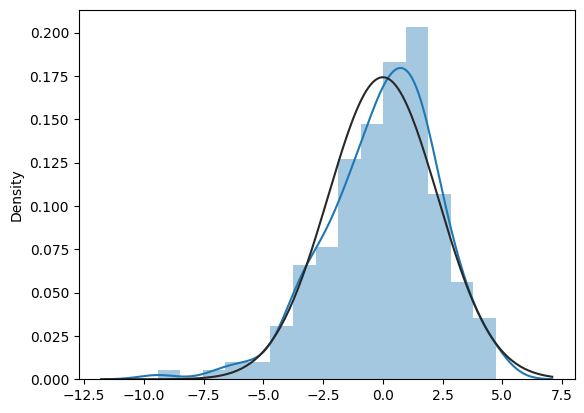

In [22]:
sns.distplot(model.resid, fit=stats.norm)

<Axes: >

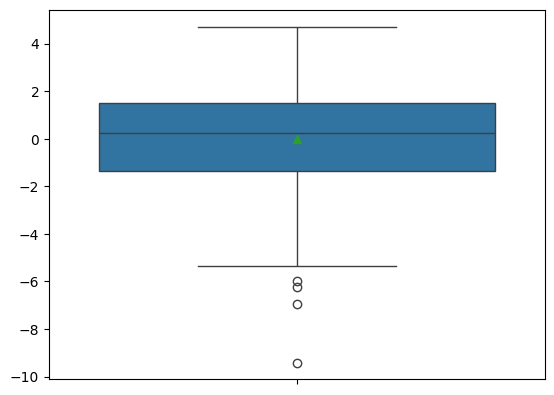

In [23]:
sns.boxplot(model.resid, showmeans=True)

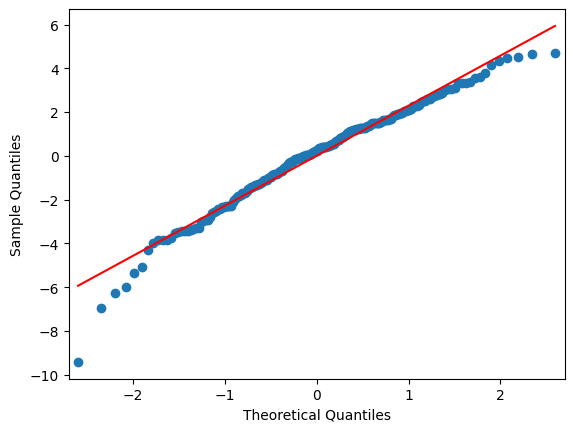

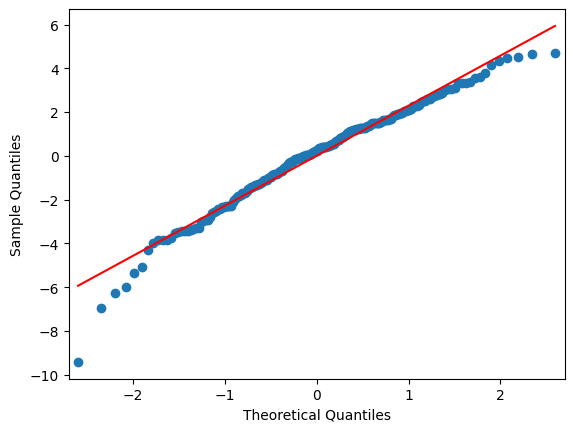

In [24]:
sm.qqplot(model.resid, line='s')

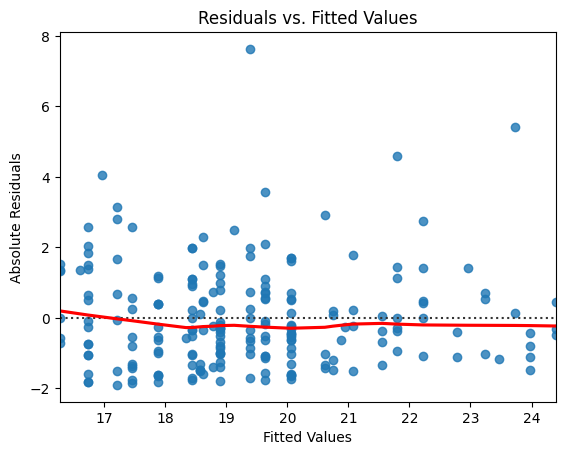

In [25]:
# график абсолютных значений остатков против предсказанных значений
y_pred = model.fittedvalues

residuals = np.abs(model.resid)

sns.residplot(x=y_pred, y=residuals, lowess=True, line_kws={'color': 'red'})
plt.xlabel('Fitted Values')
plt.ylabel('Absolute Residuals')
plt.title('Residuals vs. Fitted Values')
plt.show()

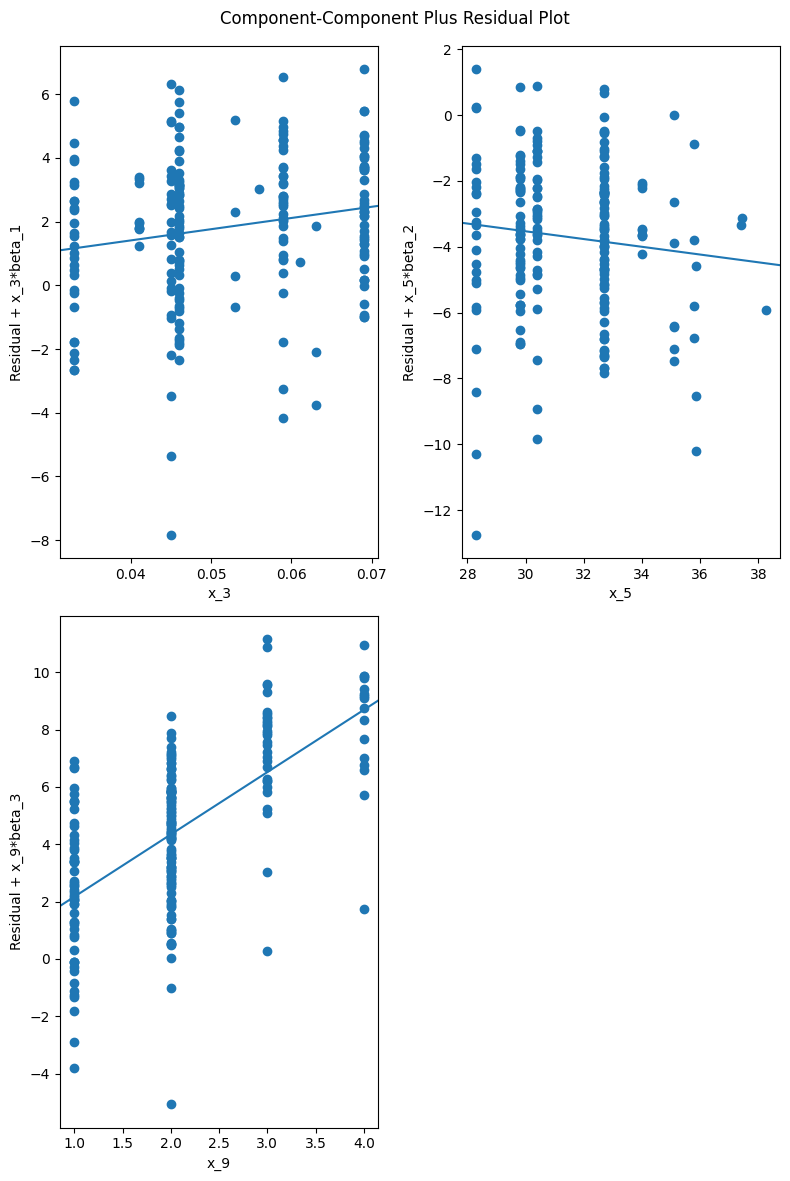

In [26]:
fig = plt.figure(figsize=(8, 12))
fig = sm.graphics.plot_ccpr_grid(model, fig=fig)

> - форма распределения остатков имеет ярко выраженный хвост слева
> - на графике абсолютных значений остатков против предсказанных значений форма разброса остатков имеет воронкообразную форму, что свидетельствует о гетероскедастичности (неоднородности)

### Выводы